In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
import seaborn as sns
import scipy.stats as stats

In [51]:
# Cell 2: Load the LFW dataset
face_data = fetch_lfw_people(min_faces_per_person=80, resize=0.4)
images = face_data.images
X = face_data.data
Y = face_data.target

In [52]:
# Cell 3: Display the number of images and classes
print(f"Input data size: {X.shape}")
print(f"Output data size: {Y.shape}")
print('Label names:', face_data.target_names)
for i in range(5):
    print(f'Class {i} has {(Y == i).sum()} samples.')

Input data size: (1140, 1850)
Output data size: (1140,)
Label names: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
Class 0 has 236 samples.
Class 1 has 121 samples.
Class 2 has 530 samples.
Class 3 has 109 samples.
Class 4 has 144 samples.


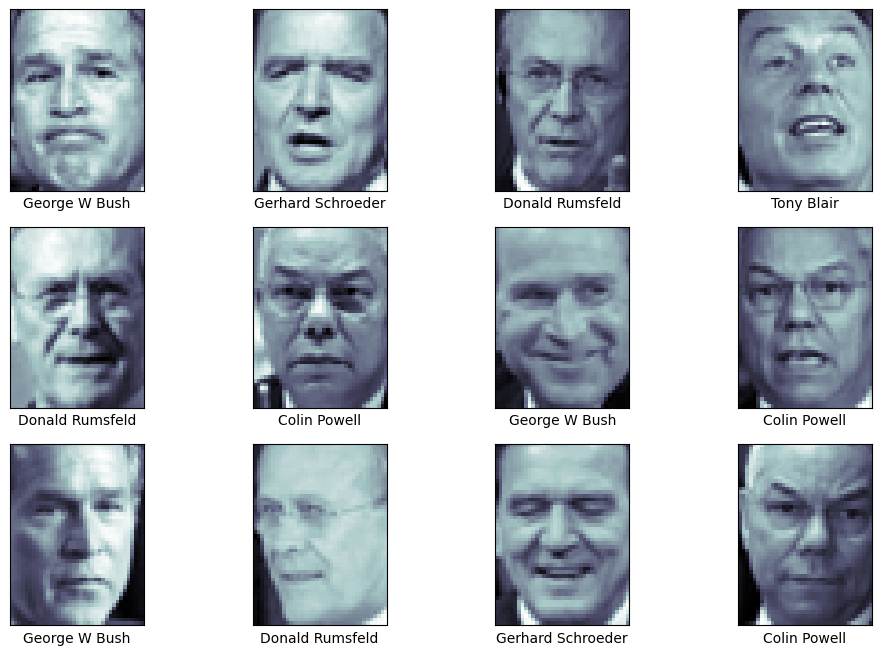

In [53]:
# Cell 4: Display some sample images with labels
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=face_data.target_names[Y[i]])
plt.show()

In [54]:
# Cell 5: Analyze Image Sizes
sizes = [img.shape[:2] for img in images]
sizes_df = pd.DataFrame(sizes, columns=['Height', 'Width'])
print("Image size statistics:")
print(sizes_df.describe())

Image size statistics:
       Height   Width
count  1140.0  1140.0
mean     50.0    37.0
std       0.0     0.0
min      50.0    37.0
25%      50.0    37.0
50%      50.0    37.0
75%      50.0    37.0
max      50.0    37.0


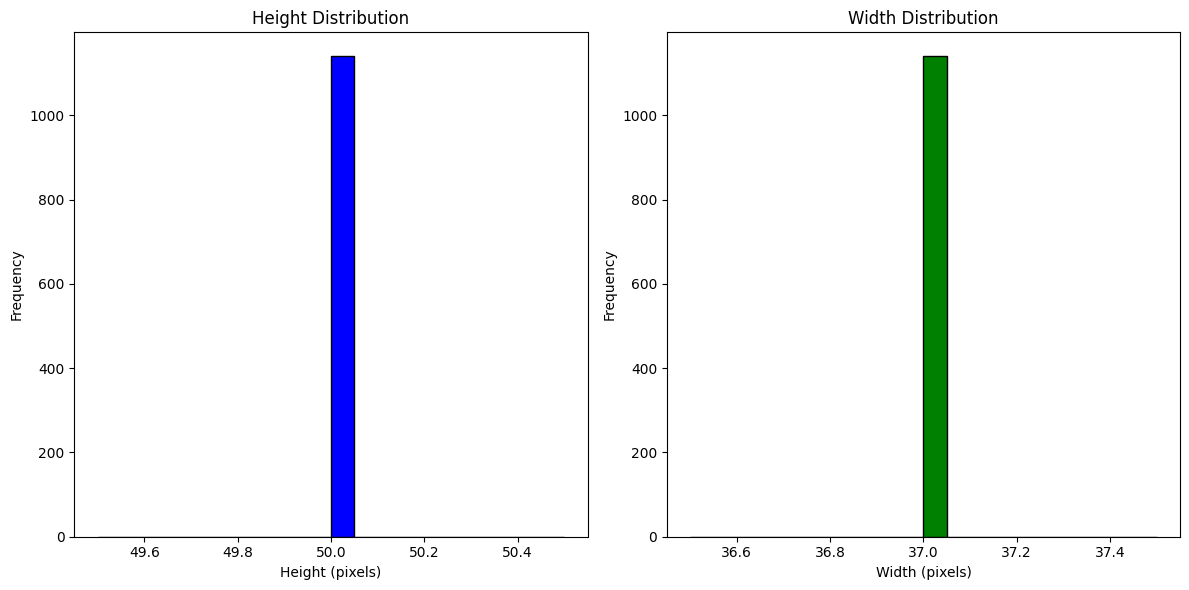

In [55]:
# Cell 6: Plot histograms for image height and width
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(sizes_df['Height'], bins=20, color='blue', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(sizes_df['Width'], bins=20, color='green', edgecolor='black')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

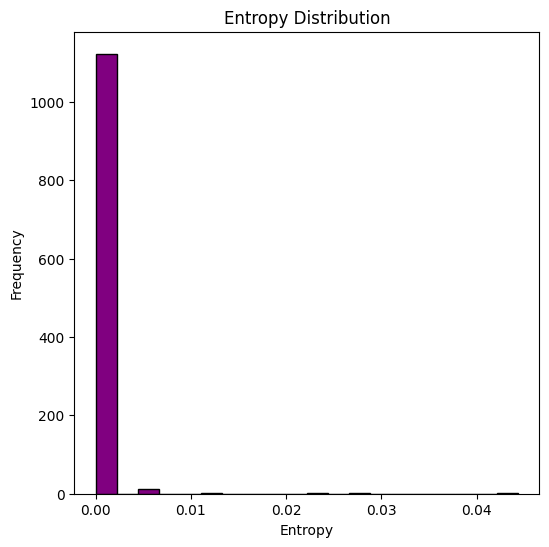

In [56]:
# Hàm tính entropy cho một ảnh
def compute_entropy(img):
    """Tính entropy của một ảnh xám."""
    hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]  # Lọc các giá trị bằng 0 để tránh lỗi log(0)
    return -np.sum(hist * np.log2(hist))

# Vẽ histogram của entropy cho tất cả các ảnh
plt.figure(figsize=(6, 6))
plt.hist([compute_entropy(img) for img in images], bins=20, color='purple', edgecolor='black')
plt.title('Entropy Distribution')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()


In [57]:
# Cell 7: Custom Metrics Functions
def confusion_matrix_manual(y_true, y_pred):
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    matrix = np.zeros((len(unique_classes), len(unique_classes)), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    return matrix

def accuracy_score_manual(y_true, y_pred):
    correct = sum(y_true == y_pred)
    total = len(y_true)
    return correct / total

def precision_score_manual(y_true, y_pred, class_label):
    matrix = confusion_matrix_manual(y_true, y_pred)
    tp = matrix[class_label, class_label]
    fp = matrix[:, class_label].sum() - tp
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall_score_manual(y_true, y_pred, class_label):
    matrix = confusion_matrix_manual(y_true, y_pred)
    tp = matrix[class_label, class_label]
    fn = matrix[class_label, :].sum() - tp
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score_manual(y_true, y_pred, class_label):
    precision = precision_score_manual(y_true, y_pred, class_label)
    recall = recall_score_manual(y_true, y_pred, class_label)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def average_precision_score(y_true, y_pred):
    classes = np.unique(y_true)
    precision_sum = sum(precision_score_manual(y_true, y_pred, c) for c in classes)
    return precision_sum / len(classes)

def average_recall_score(y_true, y_pred):
    classes = np.unique(y_true)
    recall_sum = sum(recall_score_manual(y_true, y_pred, c) for c in classes)
    return recall_sum / len(classes)

def average_f1_score(y_true, y_pred):
    classes = np.unique(y_true)
    f1_sum = sum(f1_score_manual(y_true, y_pred, c) for c in classes)
    return f1_sum / len(classes)


In [58]:
# Cell 8: Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [59]:
# Cell 9: SVM model with GridSearchCV
clf = SVC(class_weight='balanced', random_state=42)
parameters = {'C': [0.1, 1, 10], 'gamma': [1e-07, 1e-08, 1e-06], 'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)
print('The best model:\n', grid_search.best_params_)
print('The best averaged performance:', grid_search.best_score_)

The best model:
 {'C': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}
The best averaged performance: 0.8304093567251462


In [60]:
# Cell 10: Predict and evaluate SVM model
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test)
print(f'Accuracy: {accuracy_score_manual(Y_test, pred)*100:.1f}%')

Accuracy: 89.1%


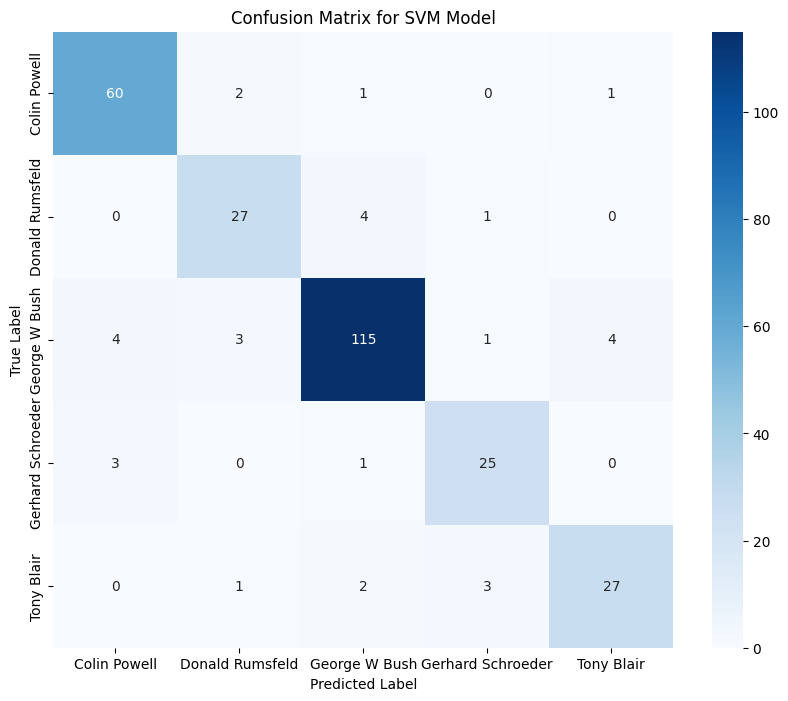

In [61]:
import seaborn as sns

# Tạo confusion matrix
cm = confusion_matrix_manual(Y_test, pred)

# Hiển thị confusion matrix dưới dạng heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=face_data.target_names, 
            yticklabels=face_data.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM Model")
plt.show()

In [62]:
# Cell 12: Tính toán và hiển thị các chỉ số cho mô hình SVM
svm_f1 = average_f1_score(Y_test, pred)
svm_accuracy = accuracy_score_manual(Y_test, pred)
svm_precision = average_precision_score(Y_test, pred)
svm_recall = average_recall_score(Y_test, pred)
print(f"F1-score: {svm_f1:.4f}, Accuracy: {svm_accuracy:.4f}, Precision: {svm_precision:.4f}, Recall: {svm_recall:.4f}")


F1-score: 0.8690, Accuracy: 0.8912, Precision: 0.8651, Recall: 0.8734


In [63]:
# Cell 13: PCA with SVM in a pipeline
pca = PCA(n_components=100, whiten=True, random_state=42)
svc = SVC(class_weight='balanced', kernel='rbf', random_state=42, probability=True)
model = Pipeline([('pca', pca), ('svc', svc)])

In [64]:
parameters_pipeline = {'svc__C': [1, 3, 10, 15], 'svc__gamma': [0.001, 0.005, 0.009]}
grid_search = GridSearchCV(model, parameters_pipeline, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)
print('Best parameters for PCA + SVM:\n', grid_search.best_params_)
print('Best averaged performance:', grid_search.best_score_)

Best parameters for PCA + SVM:
 {'svc__C': 1, 'svc__gamma': 0.009}
Best averaged performance: 0.8619883040935672


In [65]:
# Cell 14: Predict and evaluate PCA + SVM model
model_best = grid_search.best_estimator_
pred = model_best.predict(X_test)
print(f'Accuracy: {accuracy_score_manual(Y_test, pred)*100:.1f}%')

Accuracy: 91.9%


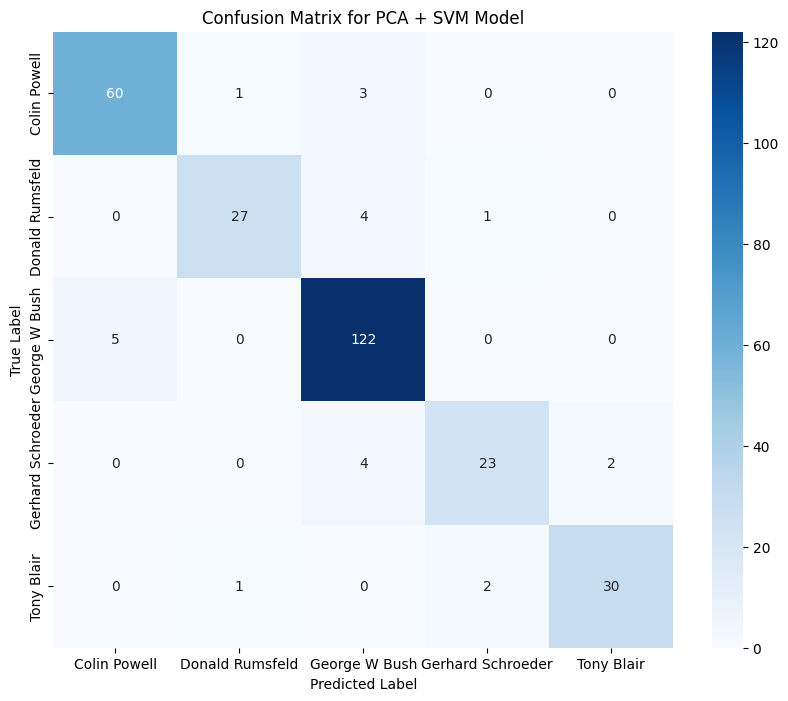

In [66]:
# Cell 15: Display custom confusion matrix for PCA + SVM model
import seaborn as sns

# Tạo confusion matrix
cm = confusion_matrix_manual(Y_test, pred)

# Hiển thị confusion matrix dưới dạng heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=face_data.target_names, 
            yticklabels=face_data.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for PCA + SVM Model")
plt.show()


In [67]:
# Cell 16: Calculate and print custom evaluation metrics for PCA + SVM model
svm_f1 = average_f1_score(Y_test, pred)
svm_accuracy = accuracy_score_manual(Y_test, pred)
svm_precision = average_precision_score(Y_test, pred)
svm_recall = average_recall_score(Y_test, pred)
print(f"F1-score: {svm_f1:.4f}, Accuracy: {svm_accuracy:.4f}, Precision: {svm_precision:.4f}, Recall: {svm_recall:.4f}")


F1-score: 0.9027, Accuracy: 0.9193, Precision: 0.9187, Recall: 0.8888


In [68]:
#Cell 17: Summary Report
metric = {
    "Accuracy": [str(round(svm_accuracy*100, 2))+"%"],
    "Precision": [str(round(svm_precision*100, 2))+"%"],
    "Recall": [str(round(svm_recall*100, 2))+"%"],
    "F1 score": [str(round(svm_f1*100, 2))+"%"]
}

Report = pd.DataFrame(metric)
Report = Report.rename(index={0: 'PCA and SVM'})
print("\nPerformance Report:")
print(Report)



Performance Report:
            Accuracy Precision  Recall F1 score
PCA and SVM   91.93%    91.87%  88.88%   90.27%
